## Breakdown of "calc_argo_outputs.py" to see what different variables and matrices look like.

In [1]:
## Import Libraries
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.optimize as sc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [8]:
np.concatenate((np.arange(1,20), np.arange(28,72)))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71])

In [12]:
chunkID = "highpoc"
makeplots = False
if chunkID == 1:
    stations = np.arange(1,21)
    # Define Layers
    layers = np.array([25.8, 26.3, 26.5,27.2], dtype=float)  # in sigma0
elif chunkID == 2:
    stations = np.arange(21,40)
    # Define Layers
    layers = np.array([25.75, 26.35, 26.55,27.2], dtype=float)  # in sigma0
elif chunkID == 3:
    stations = np.arange(40,44)
    # Define Layers
    layers = np.array([25.75, 26.35,26.5,27.3], dtype=float)  # in sigma0
elif chunkID == 4:
    stations = np.arange(44,48)
    # Define Layers
    layers = np.array([25.75, 26.35,26.55,27.3], dtype=float)  # in sigma0
elif chunkID == 5:
    stations = np.arange(48,57)
    # Define Layers
    layers = np.array([25.75, 26.2,26.55,27.3], dtype=float)  # in sigma0\
elif chunkID == 6:
    stations = np.arange(58,71)
    # Define Layers
    layers = np.array([25.99, 26.25, 26.55,27.2], dtype=float)  # in sigma0
elif chunkID == 7:
    stations = np.arange(1,72)
    # Define Layers
    layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
elif chunkID == "highnitrite":
    stations = np.arange(1,30)
    # Define Layers
    layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
elif chunkID == "lownitrite":
    stations = np.arange(30,72)
    # Define Layers
    layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
elif chunkID == "highpoc":
    stations = np.arange(20,28)
    # Define Layers
    layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
elif chunkID == "lowpochighnitrite":
    stations = np.arange(1,20)
    # Define Layers
    layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
elif chunkID == "lowpoclownitrite":
    stations = np.arange(28,72)
    # Define Layers
    layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0

In [13]:
def quickplot(xvar, yvar, cvar, huberregression, olsregression, xlabel, ylabel, lower_boundary, upper_boundary,
             huber_loss, sse):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    cax = ax.scatter(xvar, yvar,
        c=cvar)
    xfit = np.linspace(xvar.min(), xvar.max())
    
    ax.plot(xfit, xfit * huberregression.params[1] + huberregression.params[0], color="k",
        label = "Robust HuberT")
    ax.plot(xfit, xfit * olsregression.params[1] + olsregression.params[0], color="k", linestyle = ":",
        label = "OLS")
    
    textstr = f"Huber Loss={huber_loss:.4}\nSSE={sse:.4}\np={huberregression.pvalues[1]:.3}"
    
    ax.text(1.5, 0.0, textstr, transform = ax.transAxes,
        verticalalignment = "bottom")
    
    fig.colorbar(cax).set_label(r"$\sigma_{\theta}$")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(fr'$\sigma_{{\theta}}${lower_boundary:.4}-{upper_boundary:.4}')
    ax.legend(bbox_to_anchor=(1.5,1), loc="upper left")
    plt.tight_layout()
    plt.savefig(f"figures/chunk{chunkID}/{lower_boundary}-{upper_boundary}_{ylabel}vs{xlabel}.pdf",)
    plt.show()

In [14]:
# Set Directory
fpath = "output/OM_variations/experimental2/{}"
#fpath = 'output/OM_variations/anderson/{}'

# Import Data
data = pd.read_csv("data_clean.csv")
data = data.dropna()
R = np.loadtxt(fpath.format("R.txt"), delimiter=",")
Rsolve = R[[0,1,3,4,5]] # remove row for NH4

# Define Inputs
divider = 2  # Number of sublayers in each layer
K = 10000  # Number of Iterations for Monte Carlo Error Propagation

### Data Preparation ###
# Select Stations
idx_station = np.where(np.isin(data["Station"], stations))

# Save Data Vectors
rho = np.array(data["rho"])[idx_station]  # kg/m3
sigma0 = np.array(data["sigma0"])[idx_station]  # kg/m3
DIC = np.array(data["DIC"])[idx_station]  # umol/kg
DIP = np.array(data["DIP"])[idx_station]  # umol/kg
NO2 = np.array(data["NO2"])[idx_station]  # umol/kg
NO3 = np.array(data["NO3"])[idx_station]  # umol/kg
#NH4 = np.array(data["NH4"])[idx_station]  # umol/kg
Nstar = np.array(data["Nstar"])[idx_station]  # umol/kg
TA = np.array(data["TA"])[idx_station]  # umol/kg
pH = np.array(data["pH"])[idx_station]
O2 = np.array(data["O2"])[idx_station]  # umol/kg
depth = np.array(data["Depth"])[idx_station]

# divide layers up into sublayers
sl = np.zeros((len(layers) - 1, divider + 1))
for i in np.arange(0, len(layers) - 1):
    sl[i,] = np.linspace(layers[i], layers[i + 1], divider + 1)
sublayers = np.unique(sl)

### Robust Linear Regression ###
# Create Results Arrays
# for each slice of water between defined sublayers, store (slope, slope error, intercept, intercept error)
fitting_NO3 = np.zeros((len(sublayers) - 1, 4))
fitting_NO2 = np.zeros((len(sublayers) - 1, 4))
#fitting_NH4 = np.zeros((len(sublayers) - 1, 4))
fitting_Nstar = np.zeros((len(sublayers) - 1, 4))
fitting_TA = np.zeros((len(sublayers) - 1, 4))
fitting_DIC = np.zeros((len(sublayers) - 1, 4))

# Huber loss 🆚 OLS
Suppose OLS gives you a sum of squared errors (SSE) of 15.2, and your robust model has Huber loss 7.8, that suggests:
- Your RLM model fits the core of the data well, while discounting outliers.
- Huber loss may provide a better generalization if the data contain outliers or heteroskedasticity.

In [15]:
def huberregression(Y, xx):
    rf = sm.RLM(Y, xx, M=sm.robust.norms.HuberT()).fit()
    # Residuals
    resid = rf.resid
    delta = sm.robust.norms.HuberT().t
    
    # Compute Huber loss manually
    huber_loss = np.where(np.abs(resid) <= delta,
                          0.5 * resid**2,
                          delta * (np.abs(resid) - 0.5 * delta))
    
    huber_loss = np.sum(huber_loss)
    
    print(f"Total Huber loss: {huber_loss:.3f}")

    ols_model = sm.OLS(Y, xx).fit()
    sse = np.sum((Y - ols_model.fittedvalues) ** 2)
    print(f"OLS SSE: {sse:.3f}")
    
    return (rf, ols_model, huber_loss, sse)

Total Huber loss: 4.395
OLS SSE: 8.239
Total Huber loss: 1.183
OLS SSE: 2.360
Total Huber loss: 2.948
OLS SSE: 5.887
Total Huber loss: 4.666
OLS SSE: 9.395
Total Huber loss: 0.000
OLS SSE: 0.000


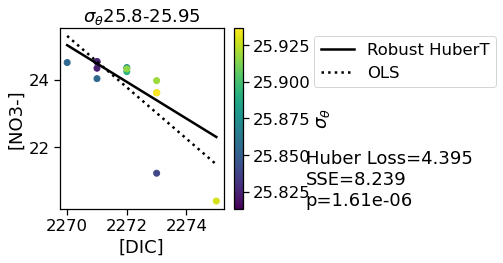

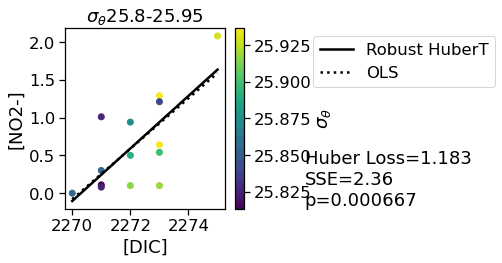

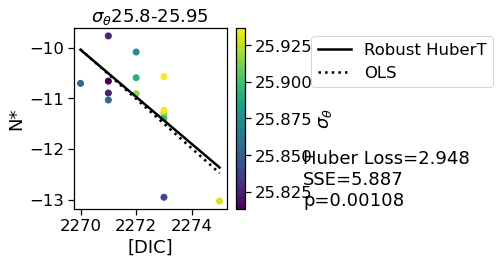

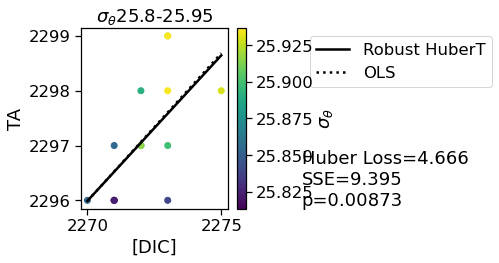

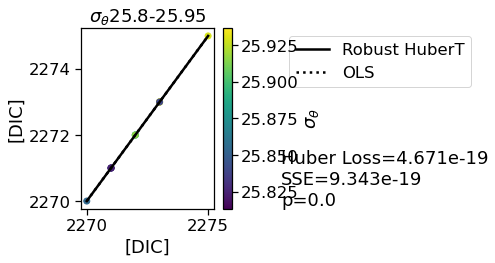

Total Huber loss: 6.850
OLS SSE: 14.456
Total Huber loss: 2.708
OLS SSE: 5.329
Total Huber loss: 2.771
OLS SSE: 5.491
Total Huber loss: 5.191
OLS SSE: 10.529
Total Huber loss: 0.000
OLS SSE: 0.000


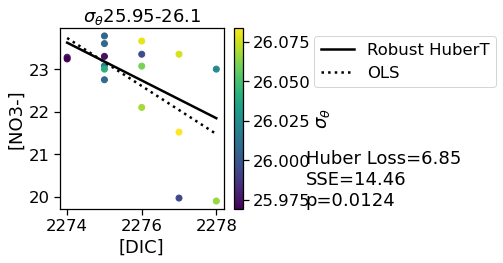

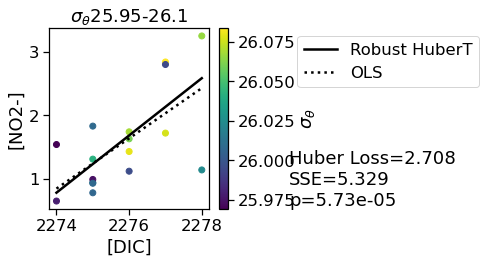

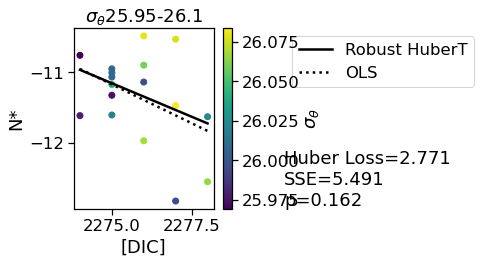

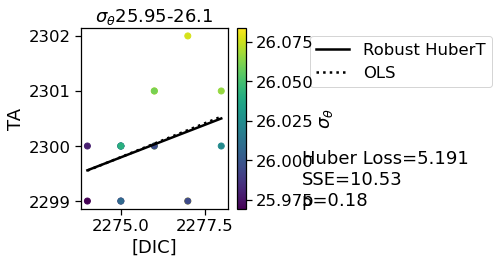

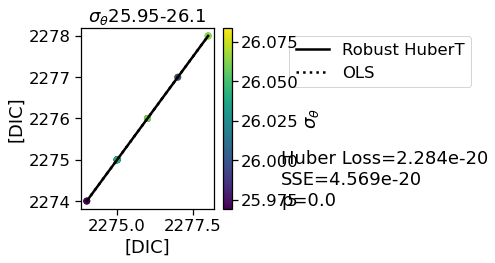

Total Huber loss: 13.297
OLS SSE: 27.234
Total Huber loss: 4.714
OLS SSE: 9.427
Total Huber loss: 8.014
OLS SSE: 16.159
Total Huber loss: 10.905
OLS SSE: 23.039
Total Huber loss: 0.000
OLS SSE: 0.000


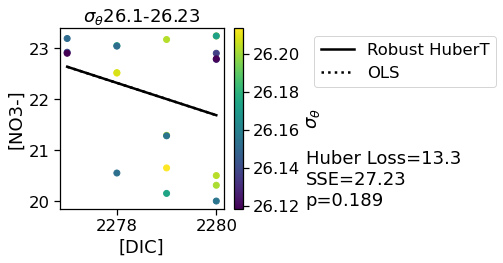

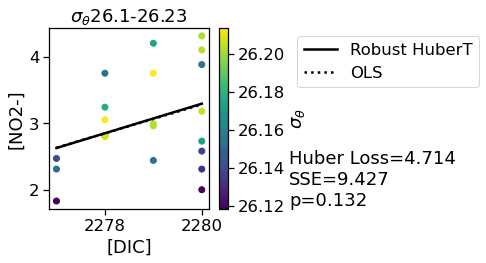

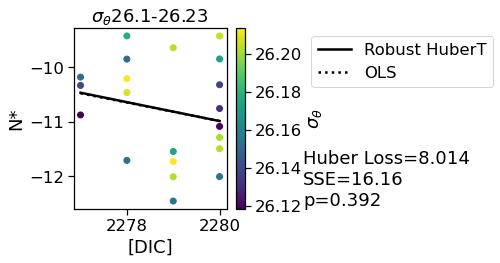

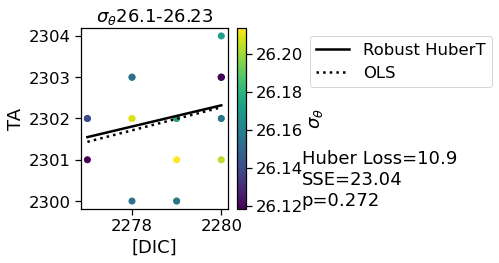

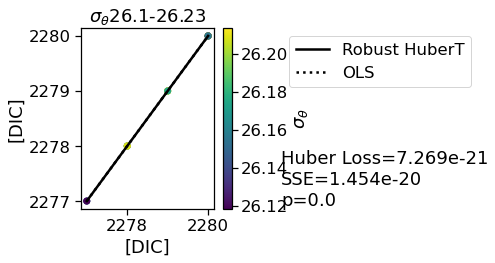

Total Huber loss: 30.088
OLS SSE: 66.955
Total Huber loss: 4.137
OLS SSE: 7.900
Total Huber loss: 22.018
OLS SSE: 46.543
Total Huber loss: 7.621
OLS SSE: 15.242
Total Huber loss: 0.000
OLS SSE: 0.000


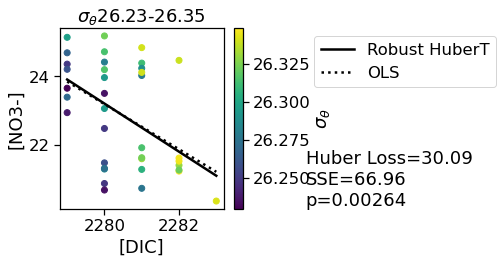

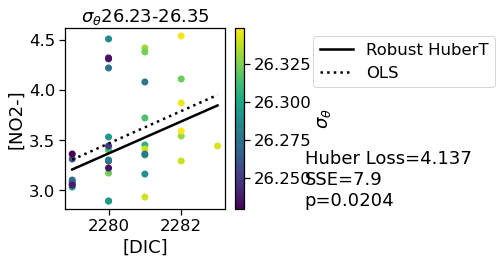

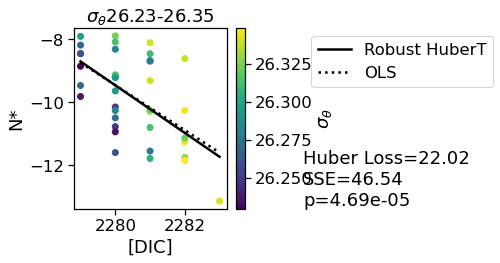

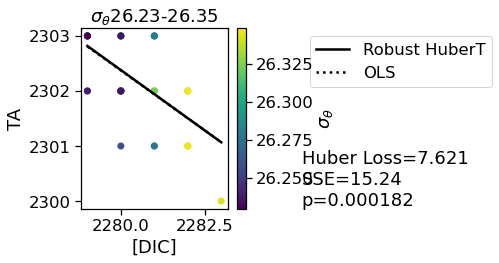

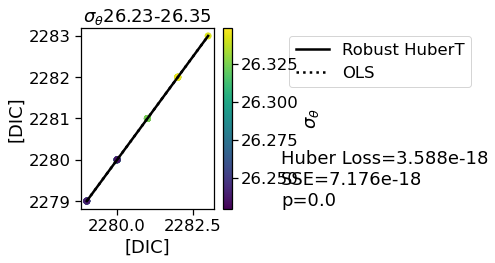

Total Huber loss: 23.923
OLS SSE: 48.361
Total Huber loss: 2.326
OLS SSE: 4.596
Total Huber loss: 23.834
OLS SSE: 49.539
Total Huber loss: 5.282
OLS SSE: 10.597
Total Huber loss: 0.000
OLS SSE: 0.000


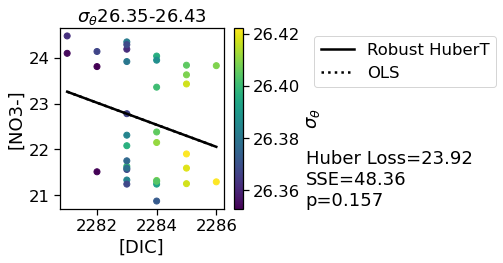

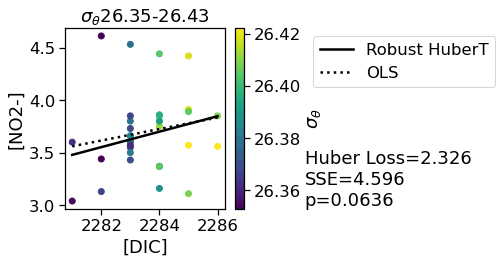

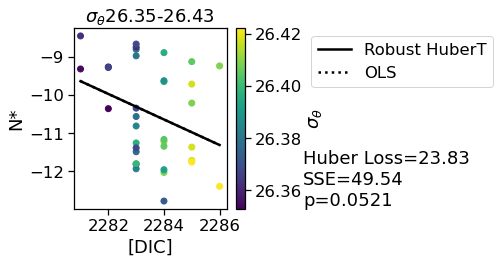

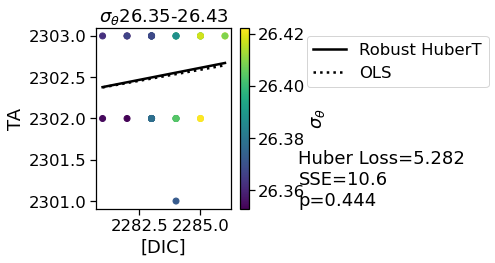

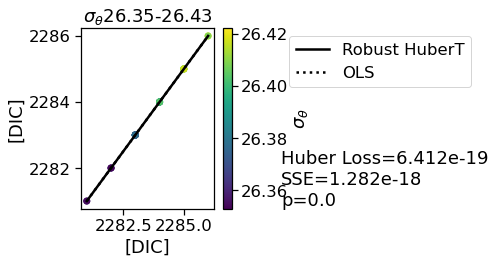

Total Huber loss: 7.730
OLS SSE: 15.476
Total Huber loss: 1.391
OLS SSE: 2.776
Total Huber loss: 9.992
OLS SSE: 20.461
Total Huber loss: 4.668
OLS SSE: 9.307
Total Huber loss: 0.000
OLS SSE: 0.000


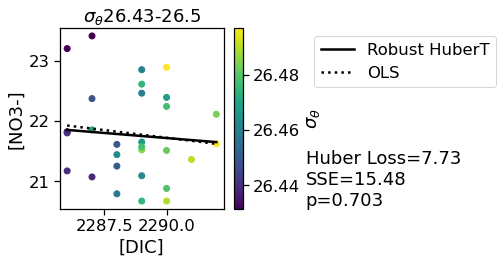

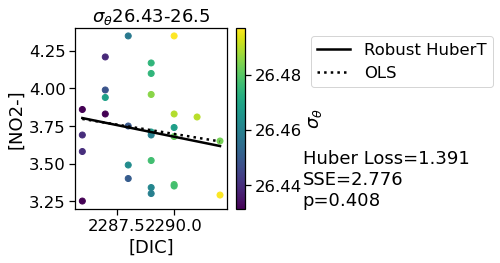

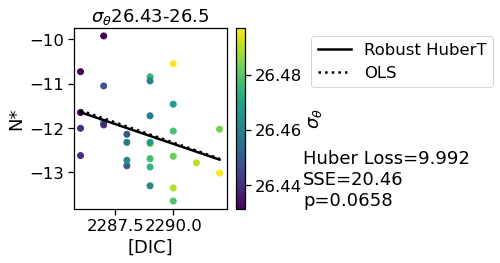

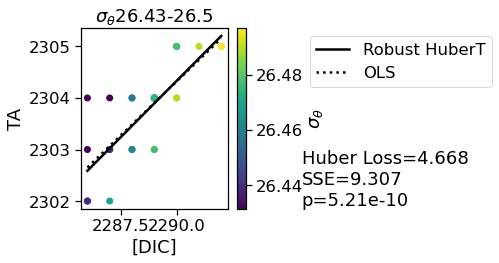

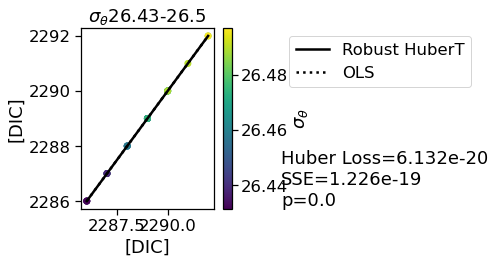

Total Huber loss: 39.897
OLS SSE: 81.568
Total Huber loss: 4.339
OLS SSE: 8.586
Total Huber loss: 40.255
OLS SSE: 82.987
Total Huber loss: 19.439
OLS SSE: 38.718
Total Huber loss: 0.000
OLS SSE: 0.000


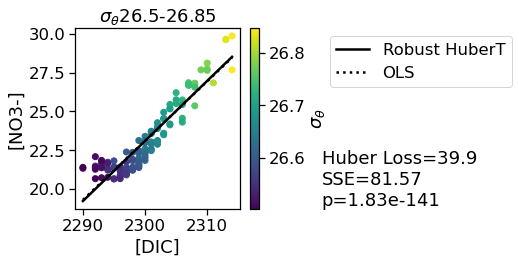

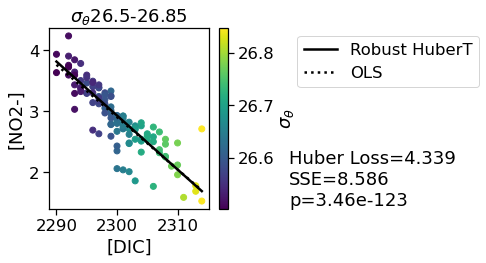

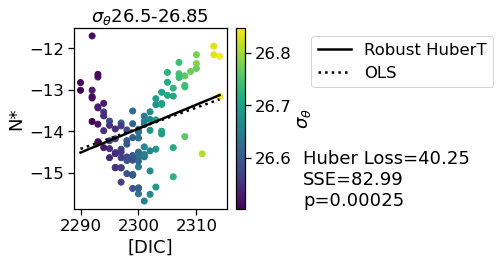

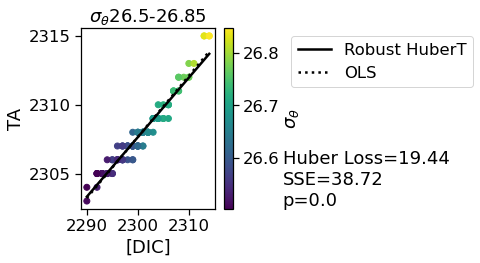

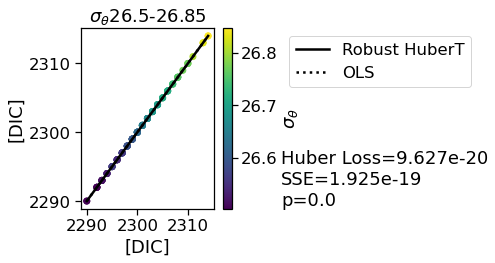

Total Huber loss: 15.530
OLS SSE: 31.273
Total Huber loss: 5.839
OLS SSE: 11.653
Total Huber loss: 4.617
OLS SSE: 9.223
Total Huber loss: 9.760
OLS SSE: 19.753
Total Huber loss: 0.000
OLS SSE: 0.000


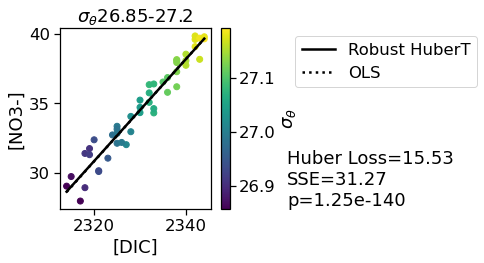

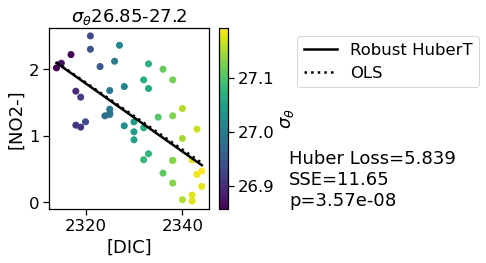

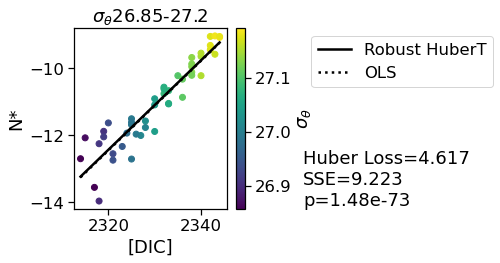

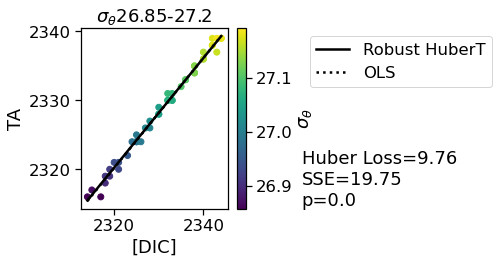

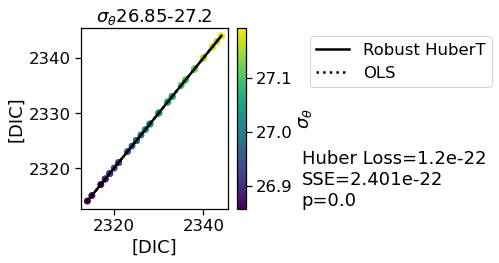

In [17]:
# Run Robost Linear Regression
# store number of data points in each layer for model stats
npoints = np.zeros((len(sublayers) - 1,1))
sigmas = np.zeros((len(sublayers) - 1,1))
depths = np.zeros((len(sublayers) - 1,1))
depthserr = np.zeros((len(sublayers) - 1,1))

for i in np.arange(0, len(sublayers) - 1):
    lower_boundary = sublayers[i]
    upper_boundary = sublayers[i + 1]
    idx_layer = np.where((sigma0 >= lower_boundary) & (sigma0 <= upper_boundary))
    if chunkID == 5:
        idx_layer = np.where((sigma0 >= lower_boundary) & (sigma0 <= upper_boundary)
            & (DIC < 2300))

    # Robust Regression
    if len(DIC[idx_layer]) > 0:
        # DIC is the x-variable against which we regress NO2-, NO2-, N*, TA, and DIC (the last of which should be 1:1)
        xx = sm.add_constant(DIC[idx_layer])
        npoints[i] = len(xx)
        sigmas[i] = (lower_boundary + upper_boundary)/2
        depths[i] = np.nanmean(depth[idx_layer])
        depthserr[i] = np.nanstd(depth[idx_layer])
        # passing a robust norm (HuberT) so we need to use RLM (Robust Linear Models), not OLS
        '''
        rf_NO3 = sm.RLM(NO3[idx_layer], xx, 
            M=sm.robust.norms.HuberT()
            ).fit()
        rf_NO2 = sm.RLM(NO2[idx_layer], xx, 
            M=sm.robust.norms.HuberT()
            ).fit()
        #rf_NH4 = sm.RLM(NH4[idx_layer], xx, M=sm.robust.norms.HuberT()).fit()
        rf_Nstar = sm.RLM(Nstar[idx_layer], xx, 
            M=sm.robust.norms.HuberT()
            ).fit()
        rf_TA = sm.RLM(TA[idx_layer], xx, 
            M=sm.robust.norms.HuberT()
            ).fit()
        rf_DIC = sm.RLM(DIC[idx_layer], xx, 
            M=sm.robust.norms.HuberT()
            ).fit()
        '''
        rf_NO3, ols_NO3, loss_NO3, sse_NO3 = huberregression(NO3[idx_layer], xx)
        rf_NO2, ols_NO2, loss_NO2, sse_NO2 = huberregression(NO2[idx_layer], xx)
        #rf_NH4, ols_NH4, loss_NH4, sse_NH4 = huberregression(NH4[idx_layer], xx)
        rf_Nstar, ols_Nstar, loss_Nstar, sse_Nstar = huberregression(Nstar[idx_layer], xx)
        rf_TA, ols_TA, loss_TA, sse_TA = huberregression(TA[idx_layer], xx)
        rf_DIC, ols_DIC, loss_DIC, sse_DIC = huberregression(DIC[idx_layer], xx)
        
        # Save Results
        # columns in "fitting_NO3" are slope, slope err, int, int err
        # rows correspond to each slice of water between sublayers
        fitting_NO3[i, :] = np.array(
            [rf_NO3.params[1], rf_NO3.bse[1], rf_NO3.params[0], rf_NO3.bse[0]]
        )
        fitting_NO2[i, :] = np.array(
            [rf_NO2.params[1], rf_NO2.bse[1], rf_NO2.params[0], rf_NO2.bse[0]]
        )
        #fitting_NH4[i, :] = np.array(
        #    [rf_NH4.params[1], rf_NH4.bse[1], rf_NH4.params[0], rf_NH4.bse[0]]
        #)
        fitting_Nstar[i, :] = np.array(
            [rf_Nstar.params[1], rf_Nstar.bse[1], rf_Nstar.params[0], rf_Nstar.bse[0]]
        )
        fitting_TA[i, :] = np.array(
            [rf_TA.params[1], rf_TA.bse[1], rf_TA.params[0], rf_TA.bse[0]]
        )
        fitting_DIC[i, :] = np.array(
            [rf_DIC.params[1], rf_DIC.bse[1], rf_DIC.params[0], rf_DIC.bse[0]]
        )

        quickplot(DIC[idx_layer], NO3[idx_layer], sigma0[idx_layer], rf_NO3, ols_NO3,
            "[DIC]", "[NO3-]", lower_boundary, upper_boundary, loss_NO3, sse_NO3)
        quickplot(DIC[idx_layer], NO2[idx_layer], sigma0[idx_layer], rf_NO2, ols_NO2,
            "[DIC]", "[NO2-]", lower_boundary, upper_boundary, loss_NO2, sse_NO2)
        quickplot(DIC[idx_layer], Nstar[idx_layer], sigma0[idx_layer], rf_Nstar, ols_Nstar,
            "[DIC]", "N*", lower_boundary, upper_boundary, loss_Nstar, sse_Nstar)
        quickplot(DIC[idx_layer], TA[idx_layer], sigma0[idx_layer], rf_TA, ols_TA,
            "[DIC]", "TA", lower_boundary, upper_boundary, loss_TA, sse_TA)
        quickplot(DIC[idx_layer], DIC[idx_layer], sigma0[idx_layer], rf_DIC, ols_DIC,
            "[DIC]", "[DIC]", lower_boundary, upper_boundary, loss_DIC, sse_DIC)

    else:
        print(f"no data {sublayers[i]}-{sublayers[i + 1]}")

In [18]:
sigmas

array([[25.875 ],
       [26.025 ],
       [26.1625],
       [26.2875],
       [26.3875],
       [26.4625],
       [26.675 ],
       [27.025 ]])

In [19]:
# organize slopes together into one array
slopes_mean = np.array(
    [
        fitting_NO3[:, 0],
        fitting_NO2[:, 0],
        #fitting_NH4[:, 0],
        fitting_Nstar[:, 0],
        fitting_TA[:, 0],
        fitting_DIC[:, 0],
    ]
).T
# organize slope errors into another array
slopes_se = np.array(
    [
        fitting_NO3[:, 1],
        fitting_NO2[:, 1],
        #fitting_NH4[:, 1],
        fitting_Nstar[:, 1],
        fitting_TA[:, 1],
        fitting_DIC[:, 1],
    ]
).T

In [20]:
# Layer Labels
ylabels = []
for i in range(len(sublayers)-1):
    label = f"sigma_theta = {sublayers[i]:.4} - {sublayers[i+1]:.4}"
    ylabels.append(label)
print(ylabels)

['sigma_theta = 25.8 - 25.95', 'sigma_theta = 25.95 - 26.1', 'sigma_theta = 26.1 - 26.23', 'sigma_theta = 26.23 - 26.35', 'sigma_theta = 26.35 - 26.43', 'sigma_theta = 26.43 - 26.5', 'sigma_theta = 26.5 - 26.85', 'sigma_theta = 26.85 - 27.2']


In [22]:
slopeoutput = pd.DataFrame(slopes_mean, columns = ["NO3vsDICslope", "NO2vsDICslope", "NstarvsDICslope","TAvsDICslope","DICvsDICslope"])
slopeoutput2 = pd.DataFrame(slopes_se, columns = ["NO3vsDICerr", "NO2vsDICerr", "NstarvsDICerr","TAvsDICerr","DICvsDICerr"])
slopeoutput["layer"] = ylabels
slopeoutput2["layer"] = ylabels
slopeoutput = slopeoutput.set_index("layer", drop=True)
slopeoutput2 = slopeoutput2.set_index("layer", drop=True)
slopeoutput = slopeoutput.join(slopeoutput2)
slopeoutput["n"] = npoints
slopeoutput["sigma0"] = sigmas
slopeoutput["depth"] = depths
slopeoutput["deptherr"] = depthserr
slopeoutput = slopeoutput[["n","sigma0","depth","deptherr",
    'NO3vsDICslope','NO3vsDICerr',
                           'NO2vsDICslope','NO2vsDICerr',
                           'NstarvsDICslope','NstarvsDICerr',
                           'TAvsDICslope','TAvsDICerr',
                           'DICvsDICslope','DICvsDICerr']]
slopeoutput.to_excel(f"output/chunk{chunkID}/slopesDF.xlsx")
slopeoutput

,n,sigma0,depth,deptherr,NO3vsDICslope,NO3vsDICerr,NO2vsDICslope,NO2vsDICerr,NstarvsDICslope,NstarvsDICerr,TAvsDICslope,TAvsDICerr,DICvsDICslope,DICvsDICerr
layer,,,,,,,,,,,,,,
sigma_theta = 25.8 - 25.95,14.0,25.8750,86.976500,7.193493,-0.547281,0.114087,0.347792,0.102205,-0.465103,0.142321,0.531058,0.202515,1.0,5.987890e-11
sigma_theta = 25.95 - 26.1,17.0,26.0250,97.688294,8.154012,-0.443655,0.177403,0.450717,0.112017,-0.190357,0.136170,0.235439,0.175693,1.0,1.115659e-11
sigma_theta = 26.1 - 26.23,21.0,26.1625,113.472762,14.067460,-0.317035,0.241528,0.222064,0.147543,-0.173107,0.202059,0.256669,0.233513,1.0,5.580238e-12
sigma_theta = 26.23 - 26.35,37.0,26.2875,151.345405,16.511219,-0.699223,0.232572,0.159920,0.068980,-0.756936,0.185960,-0.437733,0.116960,1.0,7.050860e-11
sigma_theta = 26.35 - 26.43,35.0,26.3875,196.097286,16.060175,-0.240989,0.170231,0.073481,0.039619,-0.334678,0.172291,0.058455,0.076436,1.0,2.772157e-11
sigma_theta = 26.43 - 26.5,29.0,26.4625,237.000655,16.918354,-0.033704,0.088361,-0.031082,0.037574,-0.177560,0.096519,0.436048,0.070187,1.0,7.509066e-12
sigma_theta = 26.5 - 26.85,110.0,26.6750,325.620709,49.564769,0.387761,0.015313,-0.088261,0.003739,0.057714,0.015761,0.432717,0.010538,1.0,7.320344e-13
sigma_theta = 26.85 - 27.2,47.0,27.0250,600.051745,86.291344,0.366352,0.014511,-0.051238,0.009298,0.133328,0.007349,0.795457,0.010647,1.0,3.871909e-14


In [23]:
# inspect reaction stoichiometries
# include row for NH4+ reaction stoichiometries
fpath = "output/OM_variations/experimental2/{}"
R = np.loadtxt(fpath.format("R.txt"), delimiter=",")
Rsolve = R[[0,1,2,3,4,5]] # keep row for NH4

Rdf = pd.DataFrame(Rsolve, columns = ["DNRN","denit","anammox","nitrox","CaCO3 diss"])
Rdf["tracer"] = ["NO3", "NO2", "NH4+","N*", "TA", "DIC"]

Rdf.set_index("tracer", inplace = True)
Rdf

,DNRN,denit,anammox,nitrox,CaCO3 diss
tracer,,,,,
NO3,-1.615031,0.000000,2.909,46.296,0.0
NO2,1.615031,-1.076658,-12.000,-46.296,0.0
NH4+,0.099293,0.099293,-9.091,0.000,0.0
N*,0.000000,-1.076658,-18.182,0.000,0.0
TA,0.090451,1.167109,0.182,0.000,2.0
DIC,1.000000,1.000000,-1.000,-1.000,1.0


In [24]:
# inspect reaction stoichiometries
fpath = "output/OM_variations/experimental2/{}"
R = np.loadtxt(fpath.format("R.txt"), delimiter=",")
Rsolve = R[[0,1,3,4,5]] # remove row for NH4
Reactionstoich = pd.DataFrame(Rsolve, columns = ["DNRN","denit","anammox","nitrox","CaCO3 diss"])
Reactionstoich["tracer"] = ["NO3", "NO2", "N*", "TA", "DIC"]

Reactionstoich.set_index("tracer", inplace = True)
Reactionstoich

,DNRN,denit,anammox,nitrox,CaCO3 diss
tracer,,,,,
NO3,-1.615031,0.000000,2.909,46.296,0.0
NO2,1.615031,-1.076658,-12.000,-46.296,0.0
N*,0.000000,-1.076658,-18.182,0.000,0.0
TA,0.090451,1.167109,0.182,0.000,2.0
DIC,1.000000,1.000000,-1.000,-1.000,1.0


In [25]:
slopesdf  = pd.DataFrame(slopes_mean,
                         columns = ["NO3", "NO2","N*", "TA", "DIC"])
slopesdf.reset_index().rename(columns = {"index":"sublayer"})

,sublayer,NO3,NO2,N*,TA,DIC
0,0,-0.547281,0.347792,-0.465103,0.531058,1.0
1,1,-0.443655,0.450717,-0.190357,0.235439,1.0
2,2,-0.317035,0.222064,-0.173107,0.256669,1.0
3,3,-0.699223,0.159920,-0.756936,-0.437733,1.0
4,4,-0.240989,0.073481,-0.334678,0.058455,1.0
5,5,-0.033704,-0.031082,-0.177560,0.436048,1.0
6,6,0.387761,-0.088261,0.057714,0.432717,1.0
7,7,0.366352,-0.051238,0.133328,0.795457,1.0


In [26]:
slopes_mean

array([[-0.54728117,  0.34779178, -0.46510326,  0.53105799,  1.        ],
       [-0.44365499,  0.4507166 , -0.19035706,  0.23543887,  1.        ],
       [-0.31703488,  0.22206446, -0.17310663,  0.25666879,  1.        ],
       [-0.69922308,  0.15991985, -0.75693605, -0.43773257,  1.        ],
       [-0.2409887 ,  0.07348076, -0.3346778 ,  0.05845519,  1.        ],
       [-0.03370368, -0.0310815 , -0.1775596 ,  0.43604783,  1.        ],
       [ 0.38776117, -0.08826053,  0.05771396,  0.43271673,  1.        ],
       [ 0.36635225, -0.05123799,  0.13332774,  0.79545657,  1.        ]])

In [27]:
slope_iter = np.zeros((slopes_mean.shape[1]))
i = 0
for j in range(slopes_mean.shape[1]):  # pick a value for measured Δtracer:DIC based on normal distribution
    slope_iter[j] = np.random.normal(
        loc=slopes_mean[i, j], scale=slopes_se[i, j], size=1
    )

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_2176/3000079107.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  slope_iter[j] = np.random.normal(


In [28]:
slope_iter

array([-0.68437066,  0.35082962, -0.40329776,  0.42920104,  1.        ])

In [29]:
c_temp, rnorm = sc.nnls(Rsolve, slope_iter)
c_temp

array([0.73538805, 0.24500294, 0.00767316, 0.01038929, 0.03767146])

In [30]:
0.72118468*1.614998+0*-1.076666+0*-12.0+0.03019207*-46.296+0.30900739*0

-0.23306025688936005

In [31]:
c_temp / np.sum(c_temp) 

array([0.70974846, 0.23646082, 0.00740563, 0.01002706, 0.03635803])

In [21]:
coeff_iter = c_temp / np.sum(c_temp)  # make sure X matrix sums to 1

In [23]:
coeff_iter

array([0.6256523 , 0.12850315, 0.        , 0.01892938, 0.22691518])

In [44]:
coeffs = pd.DataFrame(coeff_iter, columns = ["fraction"])
coeffs["reaction"] = ["DNRN","denit","anammox","nitrox","CaCO3 diss"]
coeffs.set_index("reaction", inplace = True)

In [69]:
coeffs

,fraction
reaction,
DNRN,0.625652
denit,0.128503
anammox,0.000000
nitrox,0.018929
CaCO3 diss,0.226915


In [53]:
Rstoich = pd.DataFrame(R, columns = ["DNRN","denit","anammox","nitrox","CaCO3 diss"])
Rstoich["tracer"] = ["NO3", "NO2", "NH4+","N*", "TA", "DIC"]

Rstoich.set_index("tracer", inplace = True)
Rstoich

,DNRN,denit,anammox,nitrox,CaCO3 diss
tracer,,,,,
NO3,-1.614998,0.000000,2.909,46.296,0.0
NO2,1.614998,-1.076666,-12.000,-46.296,0.0
NH4+,0.103270,0.103270,-9.091,0.000,0.0
N*,0.000000,-1.076666,-18.182,0.000,0.0
TA,0.094224,1.170890,0.182,0.000,2.0
DIC,1.000000,1.000000,-1.000,-1.000,1.0


In [73]:
Rstoich.loc["NO2", "nitrox"]*coeffs.loc["nitrox"] - Rstoich.loc["NO3", "anammox"]*coeffs.loc["anammox"]

fraction   -0.876354
dtype: float64

In [57]:
Rstoich.loc["NO2", "denit"]

-1.07666561128952

In [51]:
coeffs.iloc[2]

fraction    0.0
Name: anammox, dtype: float64

In [66]:
if (coeffs.loc["anammox"][0] != 0) | (coeffs.loc["denit"][0] != 0):
    print("yass")

yass


In [68]:
coeffs.loc["anammox"]

fraction    0.0
Name: anammox, dtype: float64

In [26]:
abs(R[1, 2] * coeff_iter[2] + R[1, 1] * coeff_iter[1])

0.13835491926476592

In [29]:
abs(R[1, 2] * coeff_iter[2] + R[1, 1] * coeff_iter[1]) != 0

True

In [31]:
if (coeff_iter[2] != 0) | (coeff_iter[1] != 0):
    print('yass')

yass


In [27]:
anmx_iter = abs(R[1, 2] * c_temp[2]) / abs(R[1, 2] * c_temp[2] + R[1, 1] * c_temp[1]) * 100
anmx_iter

0.0

In [28]:
denit_iter = abs(R[1, 1] * c_temp[1]) / abs(R[1, 2] * c_temp[2] + R[1, 1] * c_temp[1])* 100
denit_iter

100.0

In [112]:
slopes_obs = slopes_mean[i,:].T
slopes_obs

array([-0.15473987,  0.0219729 , -0.2839588 ,  0.2867349 ,  1.        ])

In [113]:
slopes_est = np.dot(Rsolve, coeff_iter)
slopes_est

array([-0.15916318,  0.0169986 , -0.27125234,  0.27955456,  0.92046348])

In [115]:
residuals = slopes_obs - slopes_est
residuals

array([ 0.00442331,  0.0049743 , -0.01270647,  0.00718034,  0.07953652])

In [116]:
residuals_perc = abs(residuals) / abs(slopes_obs) * 100
residuals_perc

array([ 2.85854439, 22.63835266,  4.47475689,  2.50417324,  7.95365225])

[Text(0.5, 0, '$\\Delta$$NO_3^-$'),
 Text(1.5, 0, '$\\Delta$$NO_2^-$'),
 Text(2.5, 0, '$\\Delta$$N^*$'),
 Text(3.5, 0, '$\\Delta$$TA$'),
 Text(4.5, 0, '$\\Delta$$DIC$')]

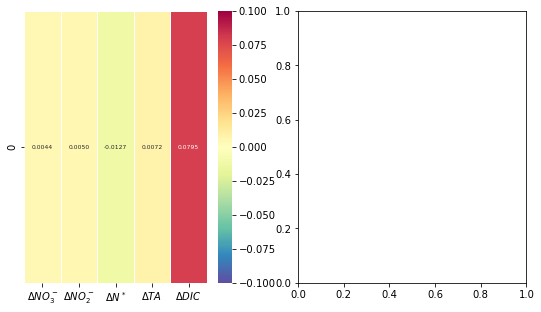

In [122]:
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
hm = sns.heatmap(
    ax=ax1,
    data=np.array([residuals]),
    annot=True,
    annot_kws={"size": 6},
    fmt=".4f",
    cmap="Spectral_r",
    vmin=-0.10,
    vmax=0.10,
    linewidths=0.5,
)

hm.set_xticklabels(
    [
        "$\Delta$$NO_3^-$",
        "$\Delta$$NO_2^-$",
        #"$\Delta$$NH_4^+$",
        "$\Delta$$N^*$",
        "$\Delta$$TA$",
        "$\Delta$$DIC$",
    ]
)